<a href="https://colab.research.google.com/github/AkankshaB123/streamlit/blob/main/anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install streamlit pandas numpy matplotlib statsmodels scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.8 MB/s eta 0:00:00


2025-04-16 15:36:42.463 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 15:36:42.465 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 15:36:42.889 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-16 15:36:42.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 15:36:42.892 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 15:36:42.893 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 15:36:42.895 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

False

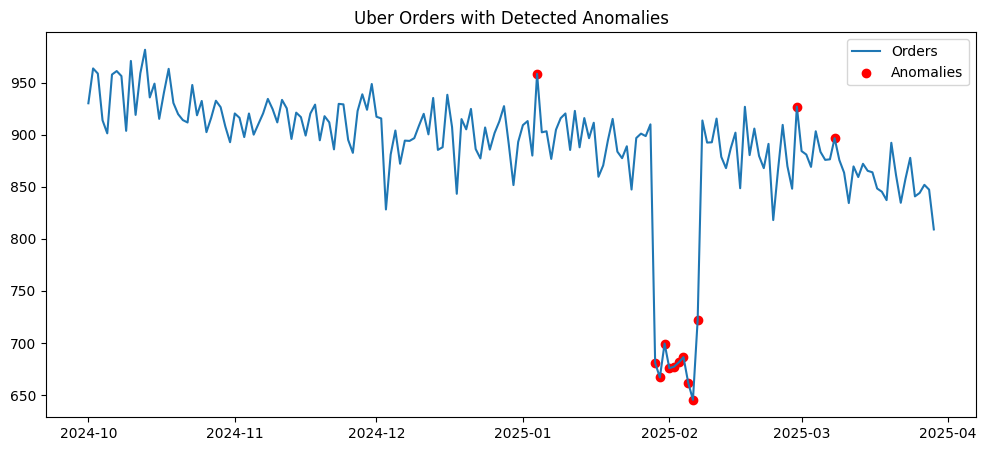

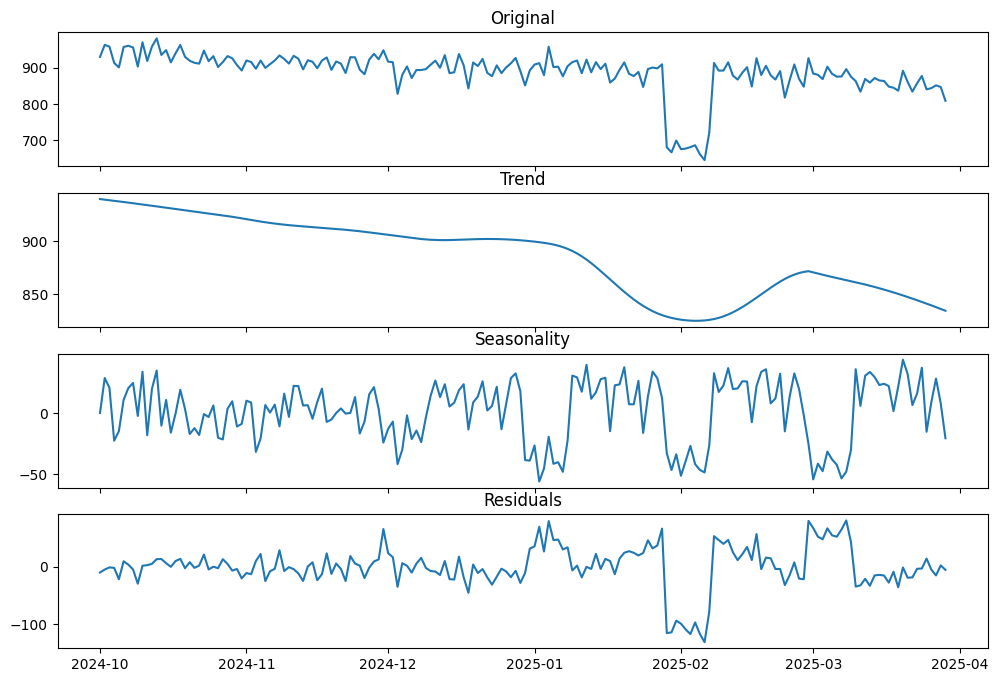

In [2]:
import streamlit as st
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore
import matplotlib.pyplot as plt

st.set_page_config(page_title="Uber Orders Anomaly Dashboard", layout="wide")

st.title("📉 Uber Orders Anomaly Detection Dashboard")

# --- Upload or Simulate Data ---
uploaded_file = st.file_uploader("Upload your time series CSV", type="csv")

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file, parse_dates=['date'])
else:
    st.subheader("Simulated Data (No file uploaded)")
    days = pd.date_range(start="2024-10-01", periods=180, freq='D')
    base_orders = 1000 + 50 * np.sin(2 * np.pi * days.dayofyear / 365)
    trend = np.linspace(0, -200, 180)
    noise = np.random.normal(0, 20, 180)
    orders = np.array(base_orders + trend + noise)
    orders[120:130] -= 200
    df = pd.DataFrame({'date': days, 'orders': orders})

# --- Time series prep ---
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# --- STL decomposition ---
stl = STL(df['orders'], period=30)
result = stl.fit()
residuals = result.resid

# --- Anomaly detection ---
z_scores = zscore(residuals)
df['z_score'] = z_scores
df['anomaly'] = np.abs(df['z_score']) > 2
df['anomaly_group'] = (df['anomaly'] != df['anomaly'].shift()).cumsum()
group_sizes = df[df['anomaly']].groupby('anomaly_group').size()
df['anomaly_type'] = df['anomaly_group'].map(
    lambda x: 'collective' if group_sizes.get(x, 0) >= 3 else 'point'
)

# --- Plots ---
st.subheader("📈 Time Series with Anomalies")

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df['orders'], label='Orders')
ax.scatter(df[df['anomaly']].index, df[df['anomaly']]['orders'], color='red', label='Anomalies')
ax.set_title('Uber Orders with Detected Anomalies')
ax.legend()
st.pyplot(fig)

# --- Decomposition Plots ---
st.subheader("🧠 STL Decomposition")
fig2, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axs[0].plot(df.index, df['orders'])
axs[0].set_title("Original")
axs[1].plot(result.trend)
axs[1].set_title("Trend")
axs[2].plot(result.seasonal)
axs[2].set_title("Seasonality")
axs[3].plot(result.resid)
axs[3].set_title("Residuals")
st.pyplot(fig2)

# --- Data preview & download ---
st.subheader("📋 Anomaly Log")
anomaly_log = df[df['anomaly']][['orders', 'z_score', 'anomaly_type']]
st.dataframe(anomaly_log)

csv = anomaly_log.reset_index().to_csv(index=False).encode('utf-8')
st.download_button("📥 Download Anomaly Log", csv, "anomaly_log.csv", "text/csv")